# Extreme Gradient Boosting Model


## EDA - Explorative Data Analysis

When maintaining the sequential data structure we get extremly poor classification performance. When shuffling the dataset in the train test split, we get high classifier performance. In order to justify randomizing first we need to prove that each sensor measurement is an independent observation aka not time dependent.

So first we can plot a `lag_plot()` to visualize time dependence, a random cluster indicates the data is independent observations.


/tmp/ipykernel_7060/3328825163.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_eda['DATE'] = pd.to_datetime(df_eda['DATE'])


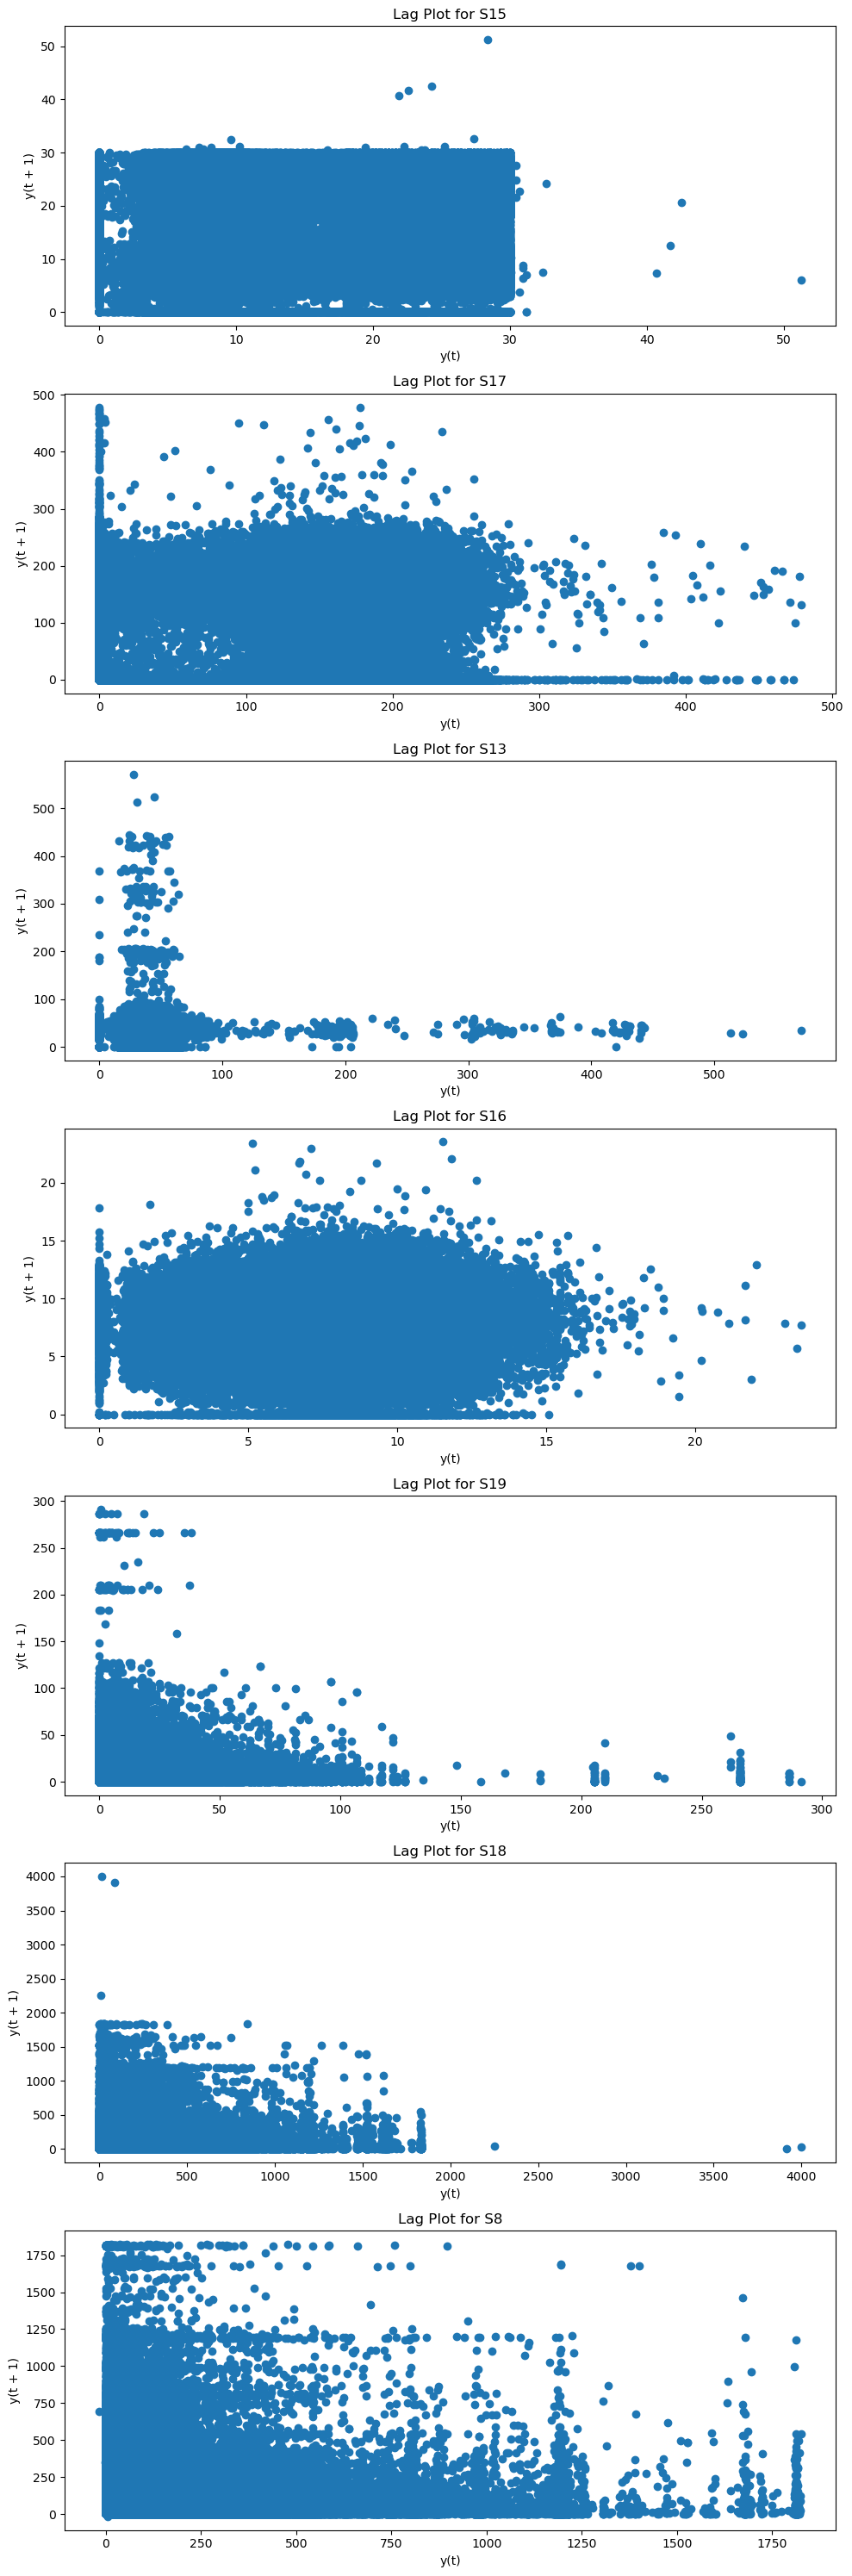

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot


file_path = "equipment_failure_data_1.csv"
df_eda = pd.read_csv(file_path)
df_eda['DATE'] = pd.to_datetime(df_eda['DATE'])
df_eda = df_eda.sort_values(by='DATE')
df_eda.set_index('DATE', inplace=True)

sensor_cols = ['S15', 'S17', 'S13', 'S16', 'S19', 'S18', 'S8']
fig, axes = plt.subplots(len(sensor_cols), 1, figsize=(10, 30))

for i, sensor in enumerate(sensor_cols):
    lag_plot(df_eda[sensor], ax=axes[i])
    axes[i].set_title(f'Lag Plot for {sensor}')

plt.tight_layout()
plt.show()


Visualize the distribution of sensor data per `WELL_GROUP`


/tmp/ipykernel_7060/1332816260.py:29: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_eda['DATE'] = pd.to_datetime(df_eda['DATE'])


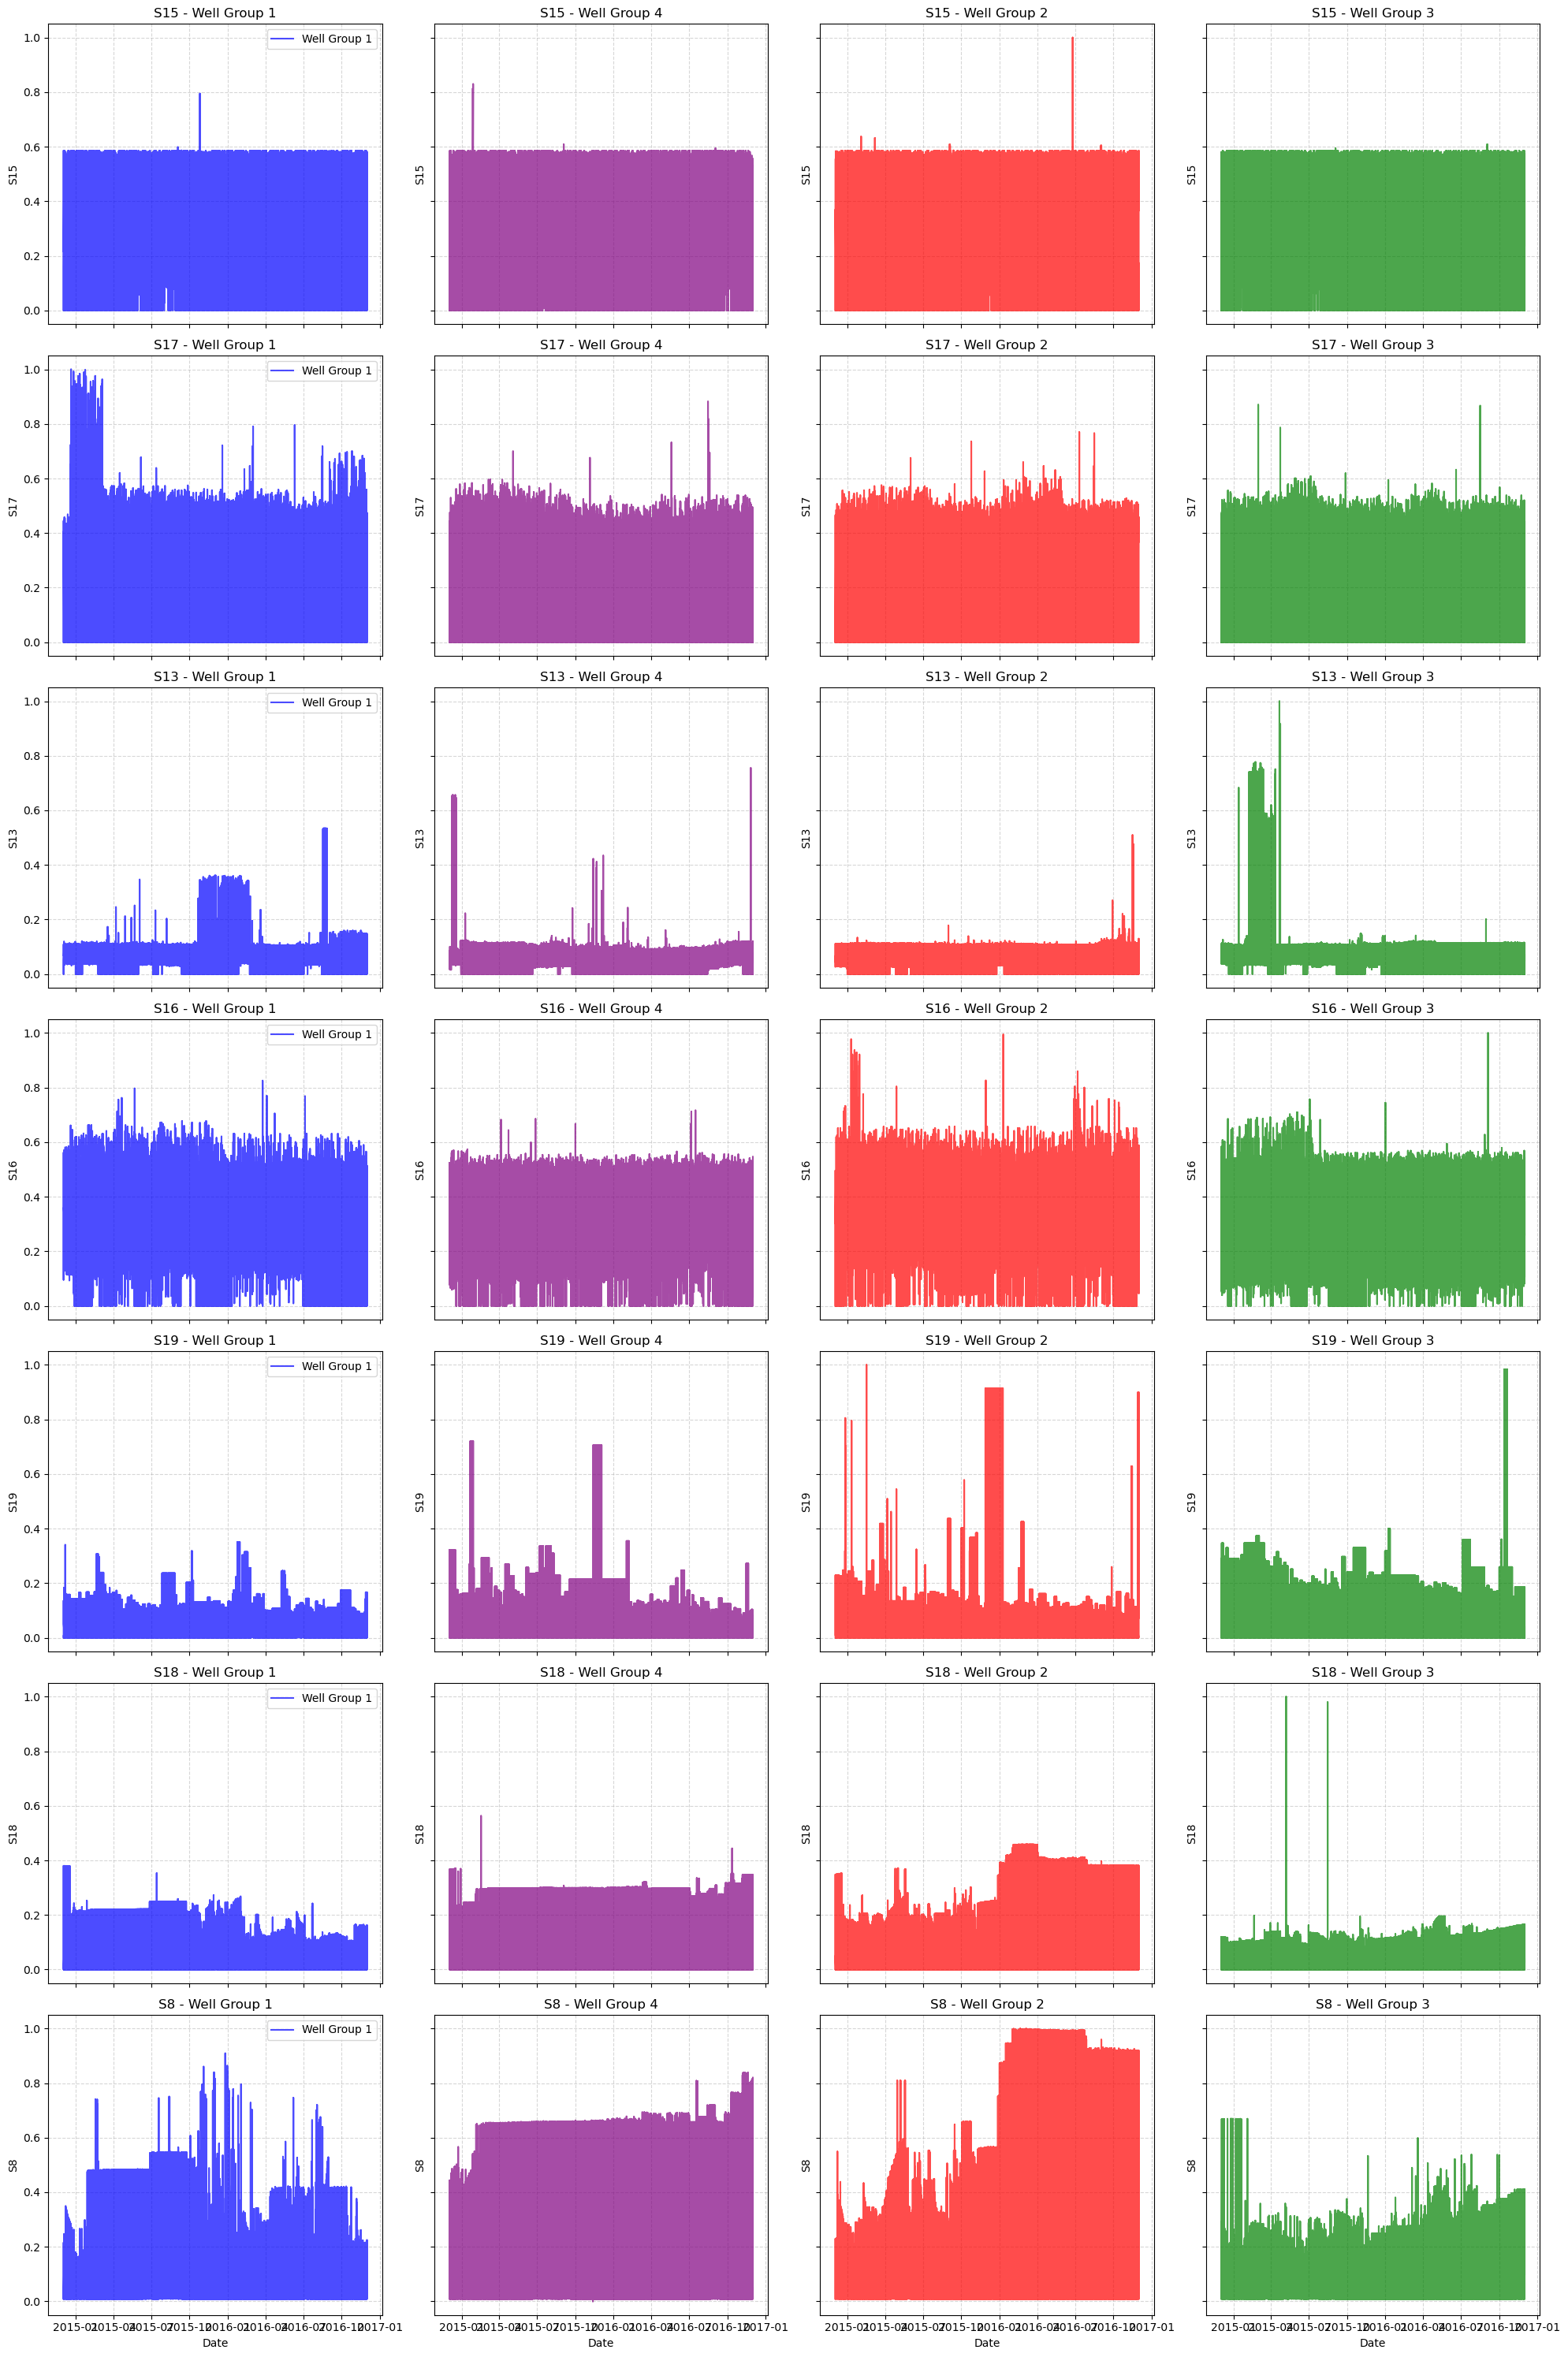

In [2]:
from sklearn.preprocessing import MinMaxScaler
def plot_sensor_data_per_well_group(df):
    sensor_cols = ['S15', 'S17', 'S13', 'S16', 'S19', 'S18', 'S8']
    well_groups = df['WELL_GROUP'].unique()
    color_map = {1: 'blue', 2: 'red', 3: 'green', 4: 'purple'}

    scaler = MinMaxScaler()
    df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    fig, axes = plt.subplots(len(sensor_cols), len(well_groups), figsize=(20, 30), sharex=True, sharey=True)

    for i, col in enumerate(sensor_cols):
        for j, well_group in enumerate(well_groups):
            well_group_data = df[df['WELL_GROUP'] == well_group]
            axes[i, j].plot(well_group_data['DATE'], well_group_data[col], 
                            label=f"Well Group {well_group}", color=color_map.get(well_group, 'black'), alpha=0.7)
            axes[i, j].set_title(f"{col} - Well Group {well_group}", fontsize=12)
            axes[i, j].set_ylabel(col, fontsize=10)
            axes[i, j].grid(True, linestyle="--", alpha=0.5)
            if i == len(sensor_cols) - 1:
                axes[i, j].set_xlabel("Date", fontsize=10)
            if j == 0:
                axes[i, j].legend()

    plt.tight_layout()
    plt.show()

# plotting the normalized sensor data to see if there are major differences between the well groups
df_eda = pd.read_csv(file_path)
df_eda['DATE'] = pd.to_datetime(df_eda['DATE'])
df_eda = df_eda.sort_values(by='DATE')
plot_sensor_data_per_well_group(df_eda)


## Data Preprocessing


In [3]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def create_target_variable(file_path, N):
    df = pd.read_csv(file_path)
    df['DATE'] = pd.to_datetime(df['DATE'])

    # first failure per machine
    failure_dates = df[df['EQUIPMENT_FAILURE'] == 1].groupby('ID')['DATE'].min().reset_index()
    failure_dates.rename(columns={'DATE': 'FAILURE_DATE'}, inplace=True)
    df = df.merge(failure_dates, on='ID', how='left')

    # use only data before or at the failure date
    df = df[df['DATE'] <= df['FAILURE_DATE']]
    df['RUL'] = (df['FAILURE_DATE'] - df['DATE']).dt.days

    df = df.drop(columns=['FAILURE_DATE', 'EQUIPMENT_FAILURE', 'DATE'])

    # create the class labels
    df['Failure_Risk'] = np.where(df['RUL'] <= N, 1, 0)
    df = df.drop(columns=['RUL'])
    # change categorical data to numerical data
    categorical_cols = ['REGION_CLUSTER', 'MAINTENANCE_VENDOR', 'MANUFACTURER', 'WELL_GROUP']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df



In [4]:
df_boosting = create_target_variable("equipment_failure_data_1.csv", 30)
df_boosting.head()
print("df_boosting shape:",df_boosting.shape)

/tmp/ipykernel_7060/1078520317.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


df_boosting shape: (84338, 37)


## Feature Extraction


In [5]:
def extract_features(df,rolling_window_size):
    # extract the features
    raw_sensors = ['AGE_OF_EQUIPMENT', 'S15', 'S17', 'S13', 'S16', 'S19', 'S18', 'S8']

    for i, col in enumerate(raw_sensors):
        # gaussian smoothing to get rid of noisy data
        df[col + '_smoothed'] = gaussian_filter1d(df[col], sigma=4)

    sensor_cols = ['S15', 'S17', 'S13', 'S16', 'S19', 'S18', 'S8']
    sensor_av_cols = [f"{col}_rolling_mean" for col in sensor_cols]
    sensor_sd_cols = [f"{col}_rolling_std" for col in sensor_cols]
    feature_cols = ['AGE_OF_EQUIPMENT', 'S15', 'S17', 'S13', 'S16', 'S19', 'S18', 'S8'] + sensor_av_cols + sensor_sd_cols

    # rolling window mean and std for each sensor
    for col in sensor_cols:
        df[col + '_rolling_mean'] = df[col].rolling(window=rolling_window_size, min_periods=1).mean()
        df[col + '_rolling_std'] = df[col].rolling(window=rolling_window_size, min_periods=1).std().fillna(0)
    
    X = df.drop(columns=['ID', 'Failure_Risk'])
    y = df['Failure_Risk']

    # scale the features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return X, y

Now we can generate the prepped data with features and normalization


In [6]:
X,y = extract_features(df_boosting, 10)
print("X shape:",X.shape)
print("y shape:",y.shape)

X shape: (84338, 57)
y shape: (84338,)


## Training Model


Fitting 3 folds for each of 36 candidates, totalling 108 fits


/mnt/dev/nvme0n1p6/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:32:56] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15567
           1       0.99      0.96      0.98      1301

    accuracy                           1.00     16868
   macro avg       1.00      0.98      0.99     16868
weighted avg       1.00      1.00      1.00     16868



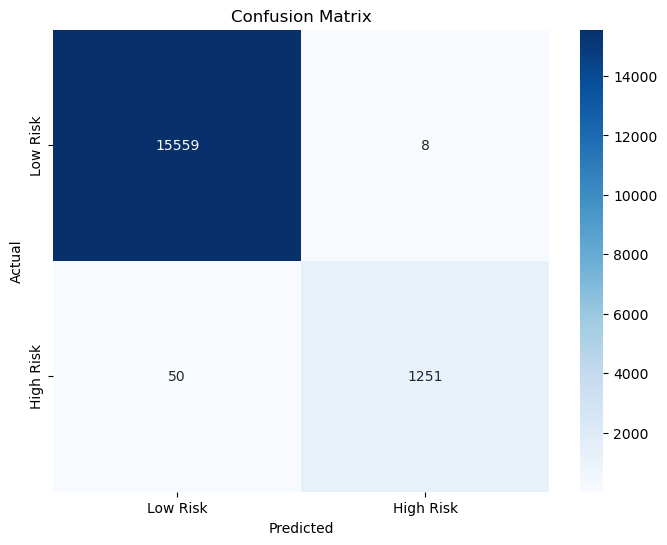

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# extreme gradient boosting setup
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# grid search to optimize hyperparameters
params = {
    'objective': 'binary:logistic',
    'device': 'cuda',  
    'eval_metric': 'logloss'
}

param_grid = {
    'max_depth': [3, 6, 9],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(**params)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

conf_matrix = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

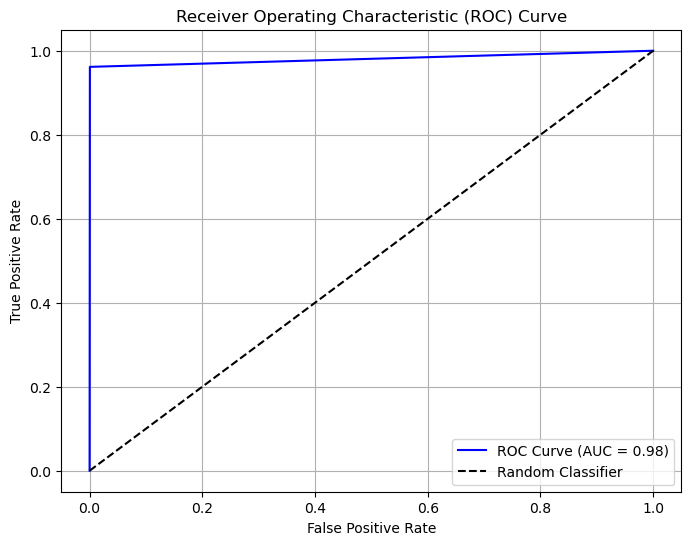

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc_score = roc_auc_score(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})',color = 'blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Random Forest


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     15567
           1       1.00      0.91      0.95      1301

    accuracy                           0.99     16868
   macro avg       0.99      0.96      0.97     16868
weighted avg       0.99      0.99      0.99     16868



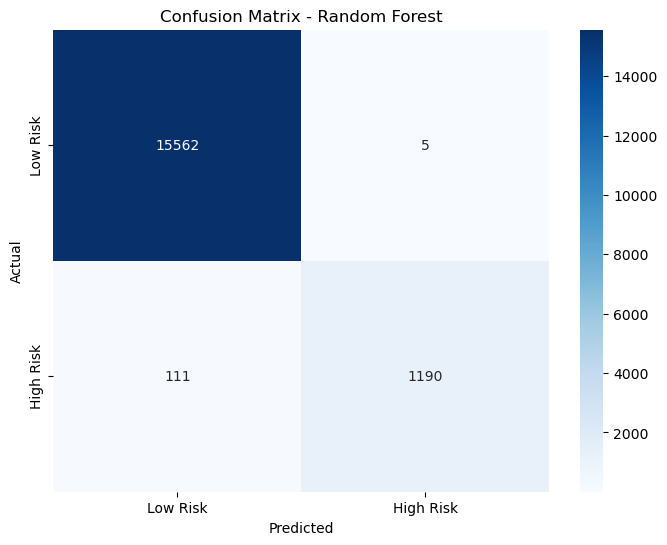

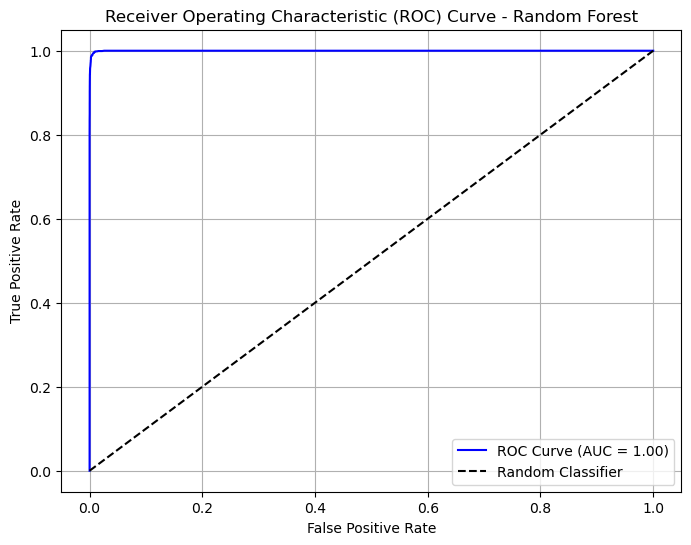

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
y_pred_rf_proba = rf_clf.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_proba)
auc_score_rf = roc_auc_score(y_test, y_pred_rf_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'ROC Curve (AUC = {auc_score_rf:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Logistic regression


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     15567
           1       0.35      0.01      0.01      1301

    accuracy                           0.92     16868
   macro avg       0.63      0.50      0.49     16868
weighted avg       0.88      0.92      0.89     16868



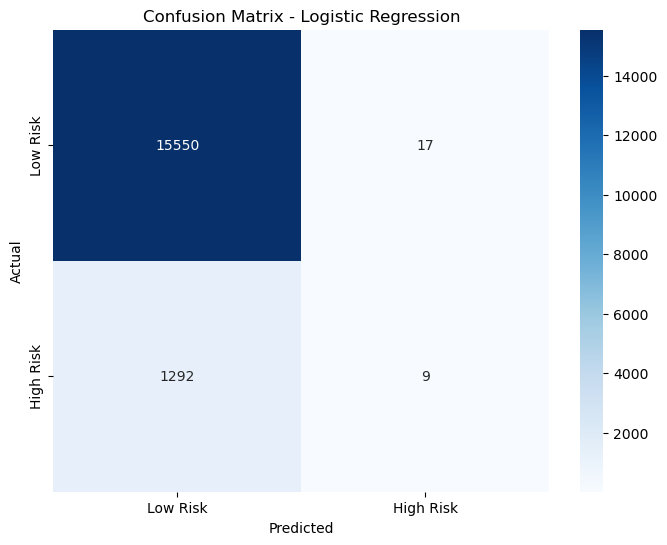

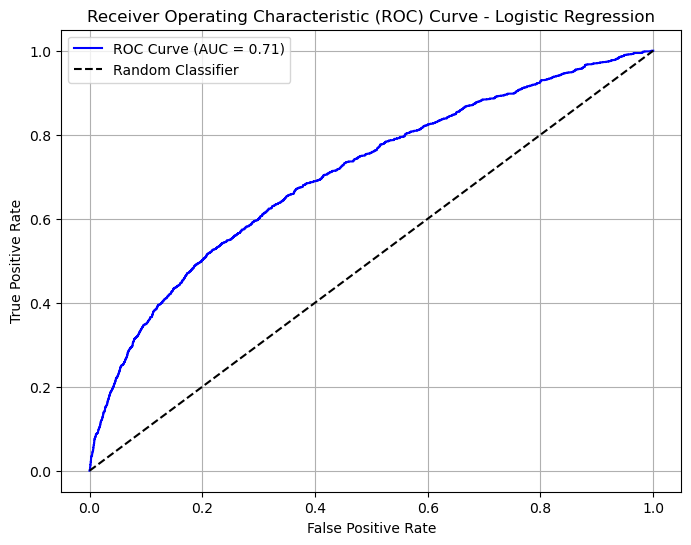

In [16]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
y_pred_log_reg_proba = log_reg.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_pred_log_reg_proba)
auc_score_log_reg = roc_auc_score(y_test, y_pred_log_reg_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'ROC Curve (AUC = {auc_score_log_reg:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# LSTM


2025-03-17 22:46:00.938135: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 22:46:01.020354: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-17 22:46:01.084323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742247961.149911    7060 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742247961.168294    7060 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 22:46:01.328375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Epoch 1/10


W0000 00:00:1742247963.055114    7060 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/mnt/dev/nvme0n1p6/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1055/1055 - 5s - 4ms/step - accuracy: 0.9251 - loss: 0.2668 - val_accuracy: 0.9229 - val_loss: 0.2526
Epoch 2/10
1055/1055 - 2s - 2ms/step - accuracy: 0.9257 - loss: 0.2450 - val_accuracy: 0.9229 - val_loss: 0.2501
Epoch 3/10
1055/1055 - 2s - 2ms/step - accuracy: 0.9259 - loss: 0.2410 - val_accuracy: 0.9235 - val_loss: 0.2456
Epoch 4/10
1055/1055 - 2s - 2ms/step - accuracy: 0.9262 - loss: 0.2364 - val_accuracy: 0.9241 - val_loss: 0.2397
Epoch 5/10
1055/1055 - 2s - 2ms/step - accuracy: 0.9271 - loss: 0.2313 - val_accuracy: 0.9251 - val_loss: 0.2335
Epoch 6/10
1055/1055 - 2s - 2ms/step - accuracy: 0.9285 - loss: 0.2267 - val_accuracy: 0.9269 - val_loss: 0.2296
Epoch 7/10
1055/1055 - 2s - 2ms/step - accuracy: 0.9294 - loss: 0.2220 - val_accuracy: 0.9271 - val_loss: 0.2251
Epoch 8/10
1055/1055 - 2s - 2ms/step - accuracy: 0.9310 - loss: 0.2179 - val_accuracy: 0.9291 - val_loss: 0.2209
Epoch 9/10
1055/1055 - 2s - 2ms/step - accuracy: 0.9314 - loss: 0.2134 - val_accuracy: 0.9315 - val_loss: 0

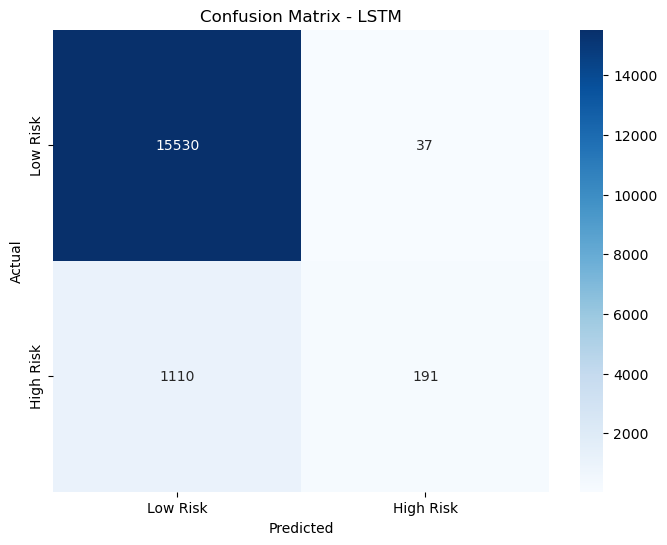

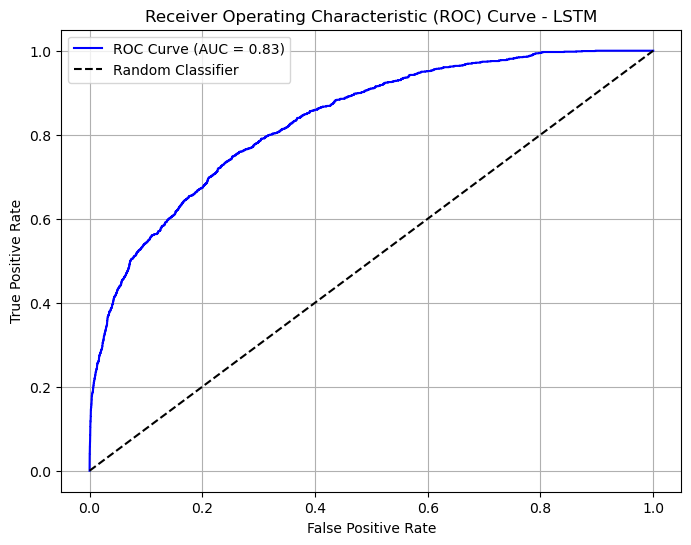

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test), verbose=2)

y_pred_lstm_proba = model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lstm))

# Confusion matrix
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()

# ROC curve
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm_proba)
auc_score_lstm = roc_auc_score(y_test, y_pred_lstm_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, label=f'ROC Curve (AUC = {auc_score_lstm:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - LSTM')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# RF Classifier with hyper parameter optimization

In [ ]:
# Set up the RDC
rf_clf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [8, 10, 20],
    'min_samples_leaf': [2, 4],  
    'max_features': ['auto', 'sqrt']
}

# Perform GridSearchCV to optimize hyperparameters
grid_search_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, scoring='f1', cv=3, n_jobs=-1, verbose=1)

# Fit it to training data 
grid_search_rf.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model_rf = grid_search_rf.best_estimator_

# Make predictions using the best model
y_pred_rf = best_model_rf.predict(X_test)
y_pred_rf_proba = best_model_rf.predict_proba(X_test)[:, 1]

## Learning curve Random Forest

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import log_loss

rf_clf = RandomForestClassifier(random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    rf_clf, X_train, y_train, 
    cv=3, 
    scoring='neg_log_loss',  # learning-curves heeft geen normale 'log_loss' argument
    train_sizes=np.linspace(0.1, 1.0, 10),  
    n_jobs=-1,  # Maakt het sneller kennelijk 
)

# From neg_log_loss --> log_loss 
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_sizes, train_scores_mean, label='Train', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Test', color='orange')
plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0,0)) # assen aanpassen naar xgboost format
plt.yticks(np.arange(0, 0.26, 0.05)) # y-as ook
plt.xlabel('Training Size')
plt.ylabel('Log Loss')
plt.title('Random Forest Classifier Log Loss')
plt.legend()
plt.show()